# Configure Aggregate Module Params

This notebook should be used as a test for ensuring correct aggregate parameters before aggregate processing.
Cells marked with `SET PARAMETERS` contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## SET PARAMETERS

### Fixed parameters for aggregate module

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [2]:
from pathlib import Path

import yaml
import pandas as pd
import matplotlib.pyplot as plt

from lib.shared.file_utils import get_filename
from lib.aggregate.load_format_data import clean_cell_data
from lib.aggregate.feature_processing import feature_transform, grouped_standardization
from lib.aggregate.collapse_data import collapse_to_sgrna, collapse_to_gene
from lib.aggregate.eval_aggregate import suggest_parameters
from lib.aggregate.cell_classification import (
    plot_mitotic_distribution_hist,
    plot_mitotic_distribution_scatter,
    split_mitotic_simple,
)
from lib.aggregate.montage_utils import create_cell_montage, add_filenames
from lib.shared.configuration_utils import CONFIG_FILE_HEADER

## SET PARAMETERS

### Testing on subset of data

- `TEST_PLATE`: Plate used for testing configuration 
- `TEST_WELL`: Well identifier used for testing configuration 
- `POPULATION_FEATURE`: The column name that identifies your perturbation groups (e.g., 'gene_symbol_0' for CRISPR screens, 'treatment' for drug screens)
- `FILTER_SINGLE_GENE`: Whether or not to ONLY keep cells with mapped_single_gene=True.

In [3]:
TEST_PLATE = 1
TEST_WELL = "A1"

POPULATION_FEATURE = "gene_symbol_0"
FILTER_SINGLE_GENE = False

In [4]:
from pyarrow.parquet import ParquetFile
import pyarrow as pa 

# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
ROOT_FP = Path(config["all"]["root_fp"])

# Load subset of data
# Takes ~1 minute
# TODO: Use actual path
merge_final_fp = "/lab/barcheese01/rkern/brieflow/testing/test_final_merge.parquet"
# merge_final_fp = ROOT_FP / "merge" / "parquets" / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "merge_final", "parquet")
merge_final = ParquetFile(merge_final_fp)
row_subset = next(merge_final.iter_batches(batch_size = 50000))
merge_final = pa.Table.from_batches([row_subset]).to_pandas() 

# Remove unassigned cells
clean_df = clean_cell_data(
    merge_final, POPULATION_FEATURE, filter_single_gene=FILTER_SINGLE_GENE
)
print(f"Loaded {len(merge_final)} cells with {len(merge_final.columns)} features")

Found 22751 cells with assigned perturbations
Loaded 50000 cells with 1684 features


## SET PARAMETERS

### Apply feature transformations

- `TRANFORMATIONS_FP`: CSV file containing feature transformation specifications. Each row defines a feature pattern and its transformation (e.g., 'log(feature)', 'log(feature-1)'), and should have a feature and transformation column

In [5]:
TRANFORMATIONS_FP = "config/transformations.tsv"

In [6]:
# load lower case version of channels
channels = [channel.lower() for channel in config["phenotype"]["channel_names"]]

# load transformations
transformations = pd.read_csv(TRANFORMATIONS_FP, sep="\t")

# perform feature transformation
transformed_df = feature_transform(clean_df, transformations, channels)
transformed_df

,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
2,1,A1,1502,501,1480.628283,1477.384343,354,277,100.674419,99.806202,...,0,0.000000,50.779623,74.421862,151.065981,0.0,0.000000,52.674577,70.256562,166.276907
11,1,A1,418,496,1476.375566,1478.313725,109,293,99.071429,99.107143,...,0,0.000000,47.622937,66.673654,164.933186,0.0,0.000000,47.218841,73.716465,172.741491
12,1,A1,1160,592,1480.918072,1475.887550,271,2036,670.875000,100.037500,...,0,0.000000,62.678918,63.863621,71.686607,0.0,0.000000,60.153852,68.126821,69.547069
14,1,A1,1185,543,1484.316222,1478.959617,300,230,101.153846,670.461538,...,0,0.000000,60.341099,60.813897,175.345937,0.0,0.000000,66.581960,67.210621,175.959281
21,1,A1,1448,547,1480.565083,1486.317149,351,1831,671.215385,103.030769,...,1,0.153846,39.735701,56.638368,71.506693,1.0,0.088496,39.549864,55.681246,79.132618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49994,1,A1,1119,507,1732.070509,1592.690987,275,375,163.288660,128.195876,...,0,0.000000,67.073506,70.118652,73.790874,0.0,0.000000,70.480546,71.998567,68.968786
49995,1,A1,300,499,1725.261631,1353.155891,56,1764,731.461538,68.461538,...,0,0.000000,69.926271,69.945190,142.847617,0.0,0.000000,67.147791,71.322136,139.871395
49996,1,A1,836,585,1585.438756,1224.802333,216,331,126.000000,36.500000,...,0,0.000000,67.556046,80.138750,89.608177,0.0,0.000000,74.020986,77.375167,88.734960
49997,1,A1,1198,465,1730.342365,1596.508621,294,362,163.545455,129.040404,...,0,0.000000,50.479507,75.907574,31.459374,0.0,0.000000,53.549231,82.735388,27.503777


In [7]:
# TODO: remove rename used during testing
# transformed_df = transformed_df.rename(columns={'well_x': 'well'})
# transformed_df = transformed_df.drop(columns=['well_y', "plate"])

## SET PARAMETERS

### Standardize features

- `CONTROL_PREFIX`: Prefix identifying control populations.
- `GROUP_COLUMNS`: Columns defining experimental groups (e.g., `['well']` for per-well standardization).
- `INDEX_COLUMNS`: Columns uniquely identifying cells (e.g., `['tile', 'cell_0']`).
- `CAT_COLUMNS`: Categorical columns to preserve.
- `FEATURE_START`: First column containing measured features.

We provide a useful function for suggesting these parameters, `suggest_parameters`.

In [8]:
suggest_parameters(clean_df, POPULATION_FEATURE)

Suggested Parameters:
--------------------------------------------------

Potential control prefixes found:
  - 'nontargeting'

First few feature columns detected:
  - 'nucleus_DAPI_mean'
  - 'nucleus_COXIV_mean'
  - 'nucleus_CENPA_mean'
  - 'nucleus_WGA_mean'
  - 'nucleus_DAPI_std'

Metadata columns detected:
  - Categorical: well, mapped_single_gene


In [9]:
CONTROL_PREFIX = "nontargeting"
GROUP_COLUMNS = ["plate", "well"]
INDEX_COLUMNS = ["tile", "cell_0"]
CAT_COLUMNS = ["gene_symbol_0", "sgRNA_0"]
FEATURE_START = "nucleus_DAPI_mean"

In [10]:
# Identify features to standardize (all columns after mapped_single_gene)
feature_start_idx = transformed_df.columns.get_loc(FEATURE_START)
target_features = transformed_df.columns[feature_start_idx:].tolist()
# Standardize the data
standardized_df = grouped_standardization(
    transformed_df,
    population_feature=POPULATION_FEATURE,
    control_prefix=CONTROL_PREFIX,
    group_columns=GROUP_COLUMNS,
    index_columns=INDEX_COLUMNS,
    cat_columns=CAT_COLUMNS,
    target_features=target_features,
    drop_features=False,
)

# add phenotype image filenames for each well/tile
standardized_df = add_filenames(standardized_df, ROOT_FP)

standardized_df

,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors,image_path
0,1,A1,1502,501,1480.628283,1477.384343,354,277,100.674419,99.806202,...,NaN,-0.790561,0.591179,0.649270,NaN,NaN,-0.592639,0.179311,0.909838,analysis_root/preprocess/images/phenotype/P-1_...
1,1,A1,418,496,1476.375566,1478.313725,109,293,99.071429,99.107143,...,NaN,-1.100966,-0.149081,0.965287,NaN,NaN,-1.159385,0.501031,1.045011,analysis_root/preprocess/images/phenotype/P-1_...
2,1,A1,1160,592,1480.918072,1475.887550,271,2036,670.875000,100.037500,...,NaN,0.379528,-0.417551,-1.159693,NaN,NaN,0.184314,-0.018723,-1.112759,analysis_root/preprocess/images/phenotype/P-1_...
3,1,A1,1185,543,1484.316222,1478.959617,300,230,101.153846,670.461538,...,NaN,0.149644,-0.708920,1.202581,NaN,NaN,0.852071,-0.103916,1.112294,analysis_root/preprocess/images/phenotype/P-1_...
4,1,A1,1448,547,1480.565083,1486.317149,351,1831,671.215385,103.030769,...,inf,-1.876538,-1.107848,-1.163793,inf,inf,-1.956044,-1.175977,-0.912328,analysis_root/preprocess/images/phenotype/P-1_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22746,1,A1,1119,507,1732.070509,1592.690987,275,375,163.288660,128.195876,...,NaN,0.811659,0.180052,-1.111739,NaN,NaN,1.257059,0.341292,-1.124851,analysis_root/preprocess/images/phenotype/P-1_...
22747,1,A1,300,499,1725.261631,1353.155891,56,1764,731.461538,68.461538,...,NaN,1.092179,0.163480,0.461983,NaN,NaN,0.910850,0.278394,0.357705,analysis_root/preprocess/images/phenotype/P-1_...
22748,1,A1,836,585,1585.438756,1224.802333,216,331,126.000000,36.500000,...,NaN,0.859108,1.137367,-0.751281,NaN,NaN,1.624842,0.841236,-0.711545,analysis_root/preprocess/images/phenotype/P-1_...
22749,1,A1,1198,465,1730.342365,1596.508621,294,362,163.545455,129.040404,...,NaN,-0.820072,0.733123,-2.076424,NaN,NaN,-0.501779,1.339657,-1.991874,analysis_root/preprocess/images/phenotype/P-1_...


## SET PARAMETERS

### Split mitotic and interphase data

- `MITOTIC_THRESHOLD_VARIABLE`: Column name used to identify mitotic cells (e.g., 'nucleus_dapi_int' for DAPI intensity)  
- `MITOTIC_THRESHOLD`: Numerical threshold to separate mitotic from interphase cells (examine intensity histogram to determine appropriate value)

**Note**: One can test multiple thresholds below and decide on a final thresholding strategy decided later.

In [11]:
# thresholding with variable 1
MITOTIC_THRESHOLD_VARIABLE_X = "nucleus_DAPI_median"
MITOTIC_THRESHOLD_X = 7

# thresholding with variable 2
MITOTIC_THRESHOLD_VARIABLE_Y = "nucleus_eccentricity"
MITOTIC_THRESHOLD_Y = 0.8

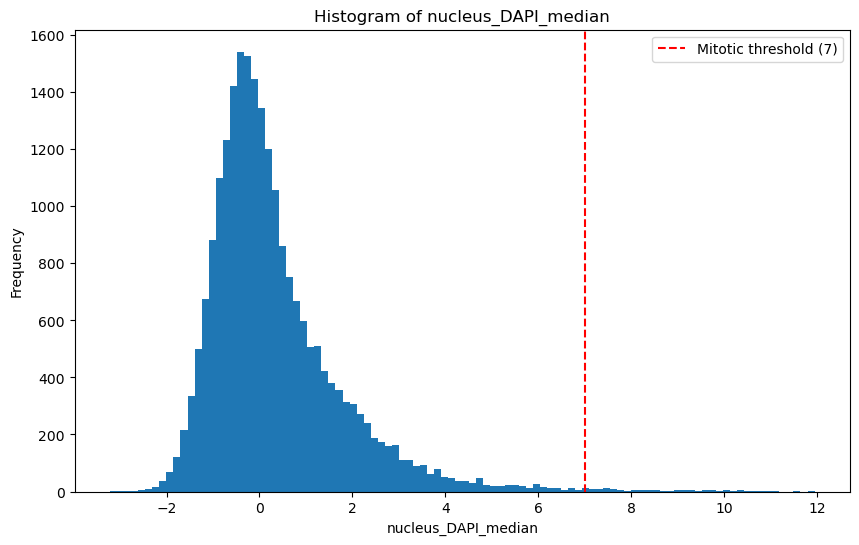

Number of mitotic cells: 128
Total cells: 22,751
Percent mitotic: 0.56%


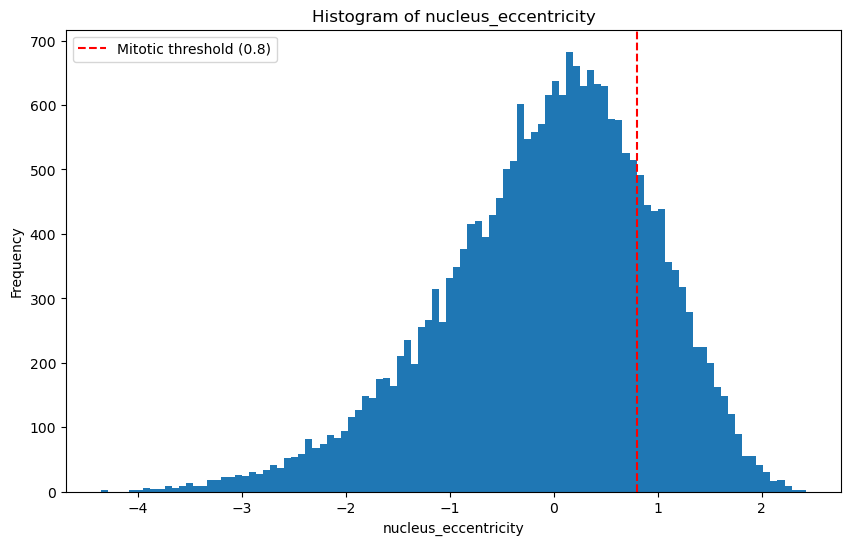

Number of mitotic cells: 4,468
Total cells: 22,751
Percent mitotic: 19.64%


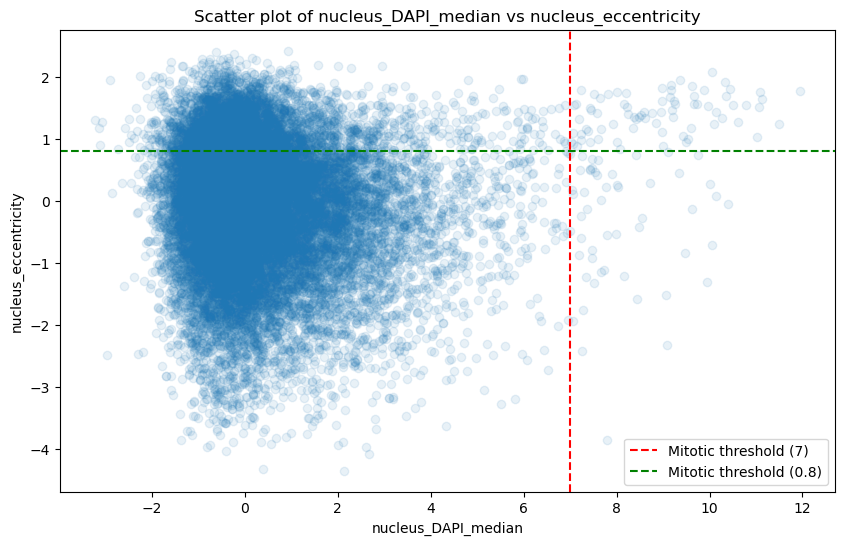

Number of mitotic cells: 77
Total cells: 22,751
Percent mitotic: 0.34%


In [12]:
percent_mitotic = plot_mitotic_distribution_hist(
    standardized_df,
    threshold_variable=MITOTIC_THRESHOLD_VARIABLE_X,
    threshold_value=MITOTIC_THRESHOLD_X,
)

percent_mitotic = plot_mitotic_distribution_hist(
    standardized_df,
    threshold_variable=MITOTIC_THRESHOLD_VARIABLE_Y,
    threshold_value=MITOTIC_THRESHOLD_Y,
)

plot_mitotic_distribution_scatter(
    standardized_df,
    threshold_variable_x=MITOTIC_THRESHOLD_VARIABLE_X,
    threshold_variable_y=MITOTIC_THRESHOLD_VARIABLE_Y,
    threshold_x=MITOTIC_THRESHOLD_X,
    threshold_y=MITOTIC_THRESHOLD_Y,
    alpha=0.1,
)

## SET PARAMETERS

### Final mitotic thresholding

- `THRESHOLD_CONDITIONS`: Columns, values, and direction to use for thresholding. Use the montages generated below to assess thresholding strategy.

In [13]:
# Final thresholding strategy
THRESHOLD_CONDITIONS = {
    "nucleus_DAPI_median": [7, "greater"],
}

Subsetting 128 mitotic cells and 22623 interphase cells


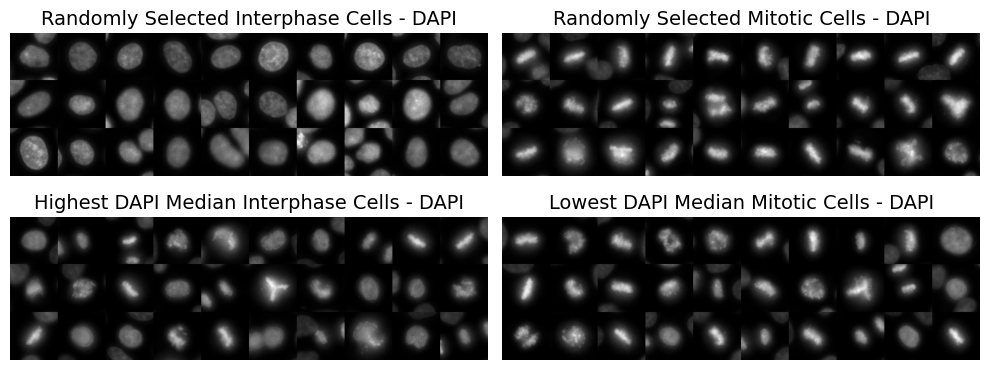

In [14]:
# Use final thresholding to split cells
mitotic_df, interphase_df = split_mitotic_simple(standardized_df, THRESHOLD_CONDITIONS)
print(
    f"Subsetting {len(mitotic_df)} mitotic cells and {len(interphase_df)} interphase cells"
)

# Get channels from config
CHANNELS = config["phenotype"]["channel_names"]

# Create figure to evaluate DAPI cutoff

titles = [
    "Randomly Selected Interphase Cells - DAPI",
    "Randomly Selected Mitotic Cells - DAPI",
    "Highest DAPI Median Interphase Cells - DAPI",
    "Lowest DAPI Median Mitotic Cells - DAPI",
]

montages = [
    create_cell_montage(
        cell_data=interphase_df,
        channels=CHANNELS,
        selection_params={
            "method": "random",
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=mitotic_df,
        channels=CHANNELS,
        selection_params={
            "method": "random",
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=interphase_df,
        channels=CHANNELS,
        selection_params={
            "method": "sorted",
            "sort_by": "nucleus_DAPI_median",
            "ascending": False,
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=mitotic_df,
        channels=CHANNELS,
        selection_params={
            "method": "sorted",
            "sort_by": "nucleus_DAPI_median",
            "ascending": True,
        },
    )["DAPI"],
]

# Initialize figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 4))

# Display each montage
for ax, title, montage in zip(axes.flat, titles, montages):
    ax.imshow(montage, cmap="gray")
    ax.set_title(title, fontsize=14)
    ax.axis("off")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [15]:
# Re-standardize mitotic population
mitotic_standardized_df = grouped_standardization(
    mitotic_df,
    population_feature=POPULATION_FEATURE,
    control_prefix=CONTROL_PREFIX,
    group_columns=GROUP_COLUMNS,
    index_columns=INDEX_COLUMNS,
    cat_columns=CAT_COLUMNS,
    target_features=target_features,
    drop_features=True,
)

# Re-standardize interphase population
interphase_standardized_df = grouped_standardization(
    interphase_df,
    population_feature=POPULATION_FEATURE,
    control_prefix=CONTROL_PREFIX,
    group_columns=GROUP_COLUMNS,
    index_columns=INDEX_COLUMNS,
    cat_columns=CAT_COLUMNS,
    target_features=target_features,
    drop_features=True,
)

# Get sgrna summaries for mitotic
mitotic_sgrna_df = collapse_to_sgrna(
    mitotic_standardized_df,
    method="median",
    target_features=target_features,
    index_features=[POPULATION_FEATURE, "sgRNA_0"],
    control_prefix=CONTROL_PREFIX,
)

# Get sgrna summaries for interphase
interphase_sgrna_df = collapse_to_sgrna(
    interphase_standardized_df,
    method="median",
    target_features=target_features,
    index_features=[POPULATION_FEATURE, "sgRNA_0"],
    control_prefix=CONTROL_PREFIX,
)

# Get gene summaries for mitotic
mitotic_gene_df = collapse_to_gene(
    mitotic_sgrna_df,
    target_features=target_features,
    index_features=[POPULATION_FEATURE],
)

# Get gene summaries for interphase
interphase_gene_df = collapse_to_gene(
    interphase_sgrna_df,
    target_features=target_features,
    index_features=[POPULATION_FEATURE],
)

# Show summary of subset aggregation
summary = pd.DataFrame(
    {
        "Stage": [
            "Raw Data",
            "Mitotic Cells",
            "Interphase Cells",
            "Mitotic sgRNAs",
            "Interphase sgRNAs",
            "Mitotic Genes",
            "Interphase Genes",
        ],
        "Count": [
            len(clean_df),
            len(mitotic_df),
            len(interphase_df),
            len(mitotic_sgrna_df),
            len(interphase_sgrna_df),
            len(mitotic_gene_df),
            len(interphase_gene_df),
        ],
    }
)
print("\nAnalysis Summary of Data Subset:")
summary

Multiple control guides not found. Renaming to ensure uniqueness.

Analysis Summary of Data Subset:


,Stage,Count
0,Raw Data,22751
1,Mitotic Cells,128
2,Interphase Cells,22623
3,Mitotic sgRNAs,124
4,Interphase sgRNAs,9542
5,Mitotic Genes,124
6,Interphase Genes,4751


## Add aggregate parameters to config file

In [16]:
# Add aggregate section
config["aggregate"] = {
    "transformations_fp": TRANFORMATIONS_FP,
    "population_feature": POPULATION_FEATURE,
    "filter_single_gene": FILTER_SINGLE_GENE,
    "feature_start": FEATURE_START,
    "control_prefix": CONTROL_PREFIX,
    "group_columns": GROUP_COLUMNS,
    "index_columns": INDEX_COLUMNS,
    "cat_columns": CAT_COLUMNS,
    "threshold_conditions": THRESHOLD_CONDITIONS,
}

# Write the updated configuration
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)